In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir("../..")

In [2]:
from dataclasses import dataclass
from typing import Callable, Literal

import einops
import numpy as np
import torch
from tqdm import tqdm
from torch import nn, Tensor
from torch.nn import functional as F

from mech_interp import plotly_utils, utils

In [3]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: mps


# 1. Toy model setup

This is a reimplementation of the model used in Anthropic's `Toy models of superposition` paper and is designed for **bottleneck superposition**, when more than $n$ features are represented in a vector space of dimension $n$. The model is as follows:

- 5-dimensional input $x$, representing 5 uniformly sampled features
- input is mapped down into 2D space
- input is mapped back up into 5D space, using the transpose of the first matrix
- a bias and ReLU activation are applied

\begin{align*}
h &= Wx \\
x' &= \text{ReLU}(W^T h + b)
\end{align*}

Each feature has a corresponding **importance** and **sparsity**:
- **importance**: how useful is this feature for achieving lower loss?
  - it is the coefficient on the error between input and output: $L = \sum_x \sum_i I_i (x_i - x_i')^2$, where $I_i$ is the importance of feature $i$.
- **sparsity**: how frequently is this feature in the input data?
  - it is the probability of the corresponding element in $x$ being zero
  - $\textit{probability}_{\textit{feature}} = 1 - \textit{sparsity}$

The values of the 5x5 matrix $W^T h$ are the dot products of each pair of features. The intuition for this operation is that each column of $W$ acts as a "unit vector", then $W^T h$ is a matrix of cosine similarities between the features, with diagonal elements representing the cosine similarity of each feature with itself.

In [4]:
# [time=2, channels=5]
input_tensor = torch.randn(2, 5)
input_tensor

tensor([[ 0.2606,  0.4550, -1.2644, -0.5405, -0.7187],
        [ 2.8302, -0.5358, -0.9837, -0.6438,  0.2255]])

In [5]:
L2_norm = input_tensor / input_tensor.norm(dim=0, keepdim=True)
print("L2_norm check: ", torch.round((L2_norm ** 2).sum(dim=0)))

L2_norm check:  tensor([1., 1., 1., 1., 1.])


In [6]:
plotly_utils.imshow(
    L2_norm.T @ L2_norm,
    title="Cosine similarities of each pair of 2D feature embeddings",
    width=600,
)

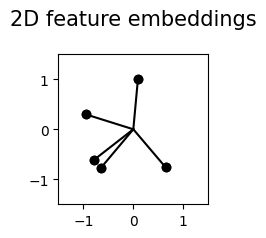

In [7]:
# [batch=1 time=2 channels=5]
utils.plot_features_in_2d(L2_norm.unsqueeze(0), title="2D feature embeddings")

### 1.1. Model definition

In [8]:
@dataclass
class ToyModelConfig:
    # `n_inst` models are optimized at once in a single training loop, so they can act as a batch dimension
    # for learnable parms: each weight/bias will have `n_inst` stacked instances along the zeroth dimension
    # allowing for efficient analysis of sparsity and importance curves
    n_inst: int
    n_features: int = 5
    d_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0
    feat_mag_distn: Literal['unif', 'normal'] = 'unif'

In [9]:
def linear_lr(step, steps):
    return 1 - (step / steps)


def constant_lr(*_):
    """Constant learning rate"""
    return 1.0


def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))

In [10]:
class ToyModel(nn.Module):
    """
    A toy model for demonstrating the setup of the paper "Toy Models of Superposition".

    Args:
        feature_probability: used to generate training data. Default is `None`, which means
            p = 1 (no sparsity).
        importance: used in the loss function. Default is `None`, which results in uniform
            importance across all features.
    """
    W: Tensor
    b_final: Tensor

    def __init__(
        self,
        cfg: ToyModelConfig,
        feature_probability: Tensor = None,
        importance: Tensor = None,
        device=device,
    ):
        super().__init__()

        if not isinstance(feature_probability, Tensor):
            feature_probability = torch.tensor(1.0)

        if not isinstance(importance, Tensor):
            importance = torch.tensor(1.0)

        self.cfg = cfg
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_inst, cfg.n_features))
        self.importance = importance.to(device).broadcast_to((cfg.n_inst, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(torch.empty((cfg.n_inst, cfg.d_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(torch.zeros((cfg.n_inst, cfg.n_features)))
        self.to(device)

    def forward(self, features: Tensor) -> Tensor:
        h = einops.einsum(features, self.W, "... inst feats, inst hidden feats -> ... inst hidden")
        out = einops.einsum(h, self.W, "... inst hidden, inst hidden feats -> ... inst feats")
        return F.relu(out + self.b_final)

    def generate_batch(self, batch_size: int) -> Tensor:
        """
        Generates a batch of training data with the specified batch size.

        `feat_mag`: random magnitudes for each feature
        `feat_seeds`: random thresholds to decide which features are activated or zeroed out.

        Returns:
            For each feature, either set it to a random magnitude or to 0. 
        """
        batch_shape = (batch_size, self.cfg.n_inst, self.cfg.n_features)
        feat_mag = torch.rand(batch_shape, device=self.W.device)
        feat_seeds = torch.rand(batch_shape, device=self.W.device)
        return torch.where(feat_seeds <= self.feature_probability, feat_mag, 0.0)

    def calculate_loss(self, out: Tensor, batch: Tensor) -> Tensor:
        """
        Calculates the loss for a given batch using the loss described in:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        The formula used is:

        .. math::

            L = \\frac{1}{BF} \\sum_{x} \\sum_{i} I_i (x_i - x'_i)^2

        Where:
        - B is the batch size
        - F is the number of features
        - :math:`x_i` are the inputs and :math:`x'_i` are the outputs
        - :math:`I_i` is the importance of feature i
        - :math:`\\sum_{i}` is the sum over all features
        - :math:`\\sum_{x}` is the sum over all elements in the batch
        """
        error = self.importance * ((batch - out) ** 2)
        loss = einops.reduce(error, "batch inst feats -> inst", "mean").sum()
        return loss

    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 5_000,
        log_freq: int = 50,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        optimizer = torch.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:
            # update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item() / self.cfg.n_inst, lr=step_lr)

In [11]:
cfg = ToyModelConfig(n_inst=8)

# `importance` takes values between 1 and ~0.66 for each feature
importance = 0.9 ** torch.arange(cfg.n_features)
print("Importance check: ", importance)

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = 50 ** -torch.linspace(0, 1, cfg.n_inst)
print("Feature probability check: ", feature_probability)

Importance check:  tensor([1.0000, 0.9000, 0.8100, 0.7290, 0.6561])
Feature probability check:  tensor([1.0000, 0.5719, 0.3270, 0.1870, 0.1069, 0.0612, 0.0350, 0.0200])


In [12]:
plotly_utils.line(
    importance,
    width=600,
    height=400,
    title="Importance of each feature (same over all instances)",
    labels={"y": "Feature importance", "x": "Feature"},
)

In [13]:
plotly_utils.line(
    feature_probability,
    width=600,
    height=400,
    title="Feature probability (varied over instances)",
    labels={"y": "Probability", "x": "Instance"},
)

In [14]:
model = ToyModel(
    cfg=cfg,
    device=device,
    importance=importance.unsqueeze(dim=0),
    feature_probability=feature_probability.unsqueeze(dim=1)
)

In [15]:
model.optimize()

100%|██████████| 5000/5000 [00:09<00:00, 539.25it/s, loss=0.0166, lr=0.001]


When there is no sparsity, the model can never represent more than 2 features faithfully, so it represents only the two most important features orthogonally in 2D space. When there is high sparsity, a pentagon structure develops. Most of the time at most one of these five
features will be active, which helps avoid interference between features.

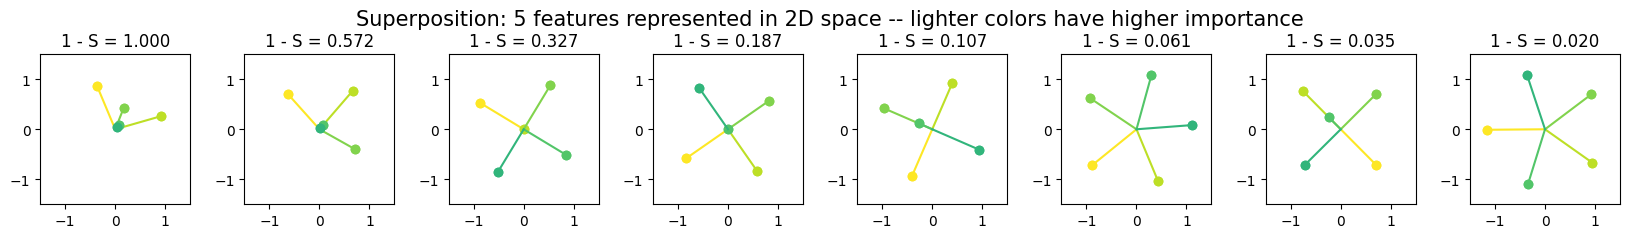

In [16]:
utils.plot_features_in_2d(
    model.W,
    colors=model.importance,
    title=f"Superposition: {cfg.n_features} features represented in 2D space -- lighter colors have higher importance",
    subplot_titles=[f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

### 1.2. Visualizing features across varying sparsity

In [17]:
cfg = ToyModelConfig(n_inst=10, n_features=100, d_hidden=20)

importance = 100 ** -torch.linspace(0, 1, cfg.n_features)
print('Importance check: ', importance.shape)
print('Importance check: ', importance[:10], '...')

feature_probability = 20 ** -torch.linspace(0, 1, cfg.n_inst)
print('Feature probability check: ', feature_probability.shape)
print('Feature probability check: ', feature_probability)

Importance check:  torch.Size([100])
Importance check:  tensor([1.0000, 0.9545, 0.9112, 0.8697, 0.8302, 0.7925, 0.7565, 0.7221, 0.6893,
        0.6579]) ...
Feature probability check:  torch.Size([10])
Feature probability check:  tensor([1.0000, 0.7169, 0.5139, 0.3684, 0.2641, 0.1893, 0.1357, 0.0973, 0.0697,
        0.0500])


In [18]:
plotly_utils.line(
    importance,
    width=600,
    height=400,
    title="Feature importance (same over all instances)",
    labels={"y": "Importance", "x": "Feature"},
)

In [19]:
plotly_utils.line(
    feature_probability,
    width=600,
    height=400,
    title="Feature probability (varied over instances)",
    labels={"y": "Probability", "x": "Instance"},
)

In [20]:
model = ToyModel(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)

In [21]:
model.optimize(steps=10_000)

100%|██████████| 10000/10000 [00:46<00:00, 216.22it/s, loss=0.00435, lr=0.001]


The ReLU output model behaves as a linear model on dense features ($1 - S = 1.0$), but as sparsity increases, superposition emerges. The model is able to represent more features by having them not be orthogonal to each other. It starts with less important features and gradually affects the most important ones. Initially, this involves arranging them in antipodal pairs, where one feature's representation vector is exactly the negative of the other's, but it gradually transitions to other geometric structures as it represents more features.

**top row plots**: dot products between all pairs of feature vectors
- as sparsity increases, the interference between features also increases
- all these plots represent matrices with rank at most `d_hidden=20`
  - the first plots are approximately submatrices of the identity, because 20 features are perfectly reconstructed and the rest is deleted
  - the later plots start to display interference as more than 20 values are plotted (the diagonals of these matrices have more than 20 non-zero elements)

**bottom row plots**: bar graphs of all the features and their corresponding embedding norms $∣∣W_i∣∣$
- as sparsity increases, the model is able to represent more features with embedding norms closer to 1
- for low sparsity, features are represented orthogonally (purple bars)
- for high sparsity, features are represented non-orthogonally (yellow bars)

In [22]:
utils.plot_features_in_Nd(
    model.W,
    height=800,
    width=1600,
    title="ReLU output model: n_features = 100, d_hidden = 20, I<sub>i</sub> = 0.9<sup>i</sup>",
    subplot_titles=[f"Feature prob = {i:.3f}" for i in feature_probability],
)

# 2. Superposition with correlation

Negative correlation is similar no sparsity, in the sense that it leads to more superposition, because the model suffers less from interference.

In [23]:
def generate_correlated_features(self: ToyModel, batch_size: int, n_correlated_pairs: int) -> Tensor:
    """
    Generates a batch of correlated features. For each pair `batch[i, j, [2k, 2k+1]]`, one of
    them is non-zero if and only if the other is non-zero.
    """
    assert torch.all((self.feature_probability == self.feature_probability[:, [0]]))
    p = self.feature_probability[:, [0]]  # shape (n_inst, 1)

    feat_mag = torch.rand((batch_size, self.cfg.n_inst, 2 * n_correlated_pairs), device=self.W.device)
    feat_set_seeds = torch.rand((batch_size, self.cfg.n_inst, n_correlated_pairs), device=self.W.device)
    feat_set_is_present = feat_set_seeds <= p
    feat_is_present = einops.repeat(
        feat_set_is_present,
        "batch instances features -> batch instances (features pair)",
        pair=2,
    )
    return torch.where(feat_is_present, feat_mag, 0.0)

In [24]:
def generate_anticorrelated_features(self: ToyModel, batch_size: int, n_anticorrelated_pairs: int) -> Tensor:
    """
    Generates a batch of anti-correlated features. For each pair `batch[i, j, [2k, 2k+1]]`, each
    of them can only be non-zero if the other one is zero.
    """
    assert torch.all((self.feature_probability == self.feature_probability[:, [0]]))
    p = self.feature_probability[:, [0]]  # shape (n_inst, 1)

    assert p.max().item() <= 0.5, "For anticorrelated features, must have 2p < 1"

    feat_mag = torch.rand((batch_size, self.cfg.n_inst, 2 * n_anticorrelated_pairs), device=self.W.device)
    even_feat_seeds, odd_feat_seeds = torch.rand(
        (2, batch_size, self.cfg.n_inst, n_anticorrelated_pairs),
        device=self.W.device,
    )
    even_feat_is_present = even_feat_seeds <= p
    odd_feat_is_present = (even_feat_seeds > p) & (odd_feat_seeds <= p / (1 - p))
    feat_is_present = einops.rearrange(
        torch.stack([even_feat_is_present, odd_feat_is_present], dim=0),
        "pair batch instances features -> batch instances (features pair)",
    )
    return torch.where(feat_is_present, feat_mag, 0.0)

In [ ]:
def generate_uncorrelated_features(self: ToyModel, batch_size: int, n_uncorrelated: int) -> Tensor:
    """
    Generates a batch of uncorrelated features.
    """
    if n_uncorrelated == self.cfg.n_features:
        p = self.feature_probability
    else:
        assert torch.all((self.feature_probability == self.feature_probability[:, [0]]))
        p = self.feature_probability[:, [0]]  # shape (n_inst, 1)

    if n_uncorrelated == self.cfg.n_features:
        p = self.feature_probability
    else:
        assert torch.all((self.feature_probability == self.feature_probability[:, [0]]))
        p = self.feature_probability[:, [0]]  # shape (n_inst, 1)

    feat_mag = torch.rand((batch_size, self.cfg.n_inst, n_uncorrelated), device=self.W.device)
    feat_seeds = torch.rand((batch_size, self.cfg.n_inst, n_uncorrelated), device=self.W.device)
    return torch.where(feat_seeds <= p, feat_mag, 0.0)

In [ ]:
def generate_batch(self: ToyModel, batch_size) -> Tensor:
    """
    Generates a batch of data, with optional correlated & anticorrelated features.
    """
    n_corr_pairs = self.cfg.n_correlated_pairs
    n_anti_pairs = self.cfg.n_anticorrelated_pairs
    n_uncorr = self.cfg.n_features - 2 * n_corr_pairs - 2 * n_anti_pairs

    data = []
    if n_corr_pairs > 0:
        data.append(generate_correlated_features(self, batch_size, n_corr_pairs))
    if n_anti_pairs > 0:
        data.append(generate_anticorrelated_features(self, batch_size, n_anti_pairs))
    if n_uncorr > 0:
        data.append(generate_uncorrelated_features(self, batch_size, n_uncorr))
    batch = torch.cat(data, dim=-1)
    return batch


ToyModel.generate_batch = generate_batch

In [27]:
cfg = ToyModelConfig(n_inst=30, n_features=4, d_hidden=2, n_correlated_pairs=1, n_anticorrelated_pairs=1)

feature_probability = 10 ** -torch.linspace(0.5, 1, cfg.n_inst).to(device)

model = ToyModel(cfg=cfg, device=device, feature_probability=feature_probability[:, None])

# Generate a batch of 4 features: first 2 are correlated, second 2 are anticorrelated
batch = model.generate_batch(batch_size=100_000)
corr0, corr1, anticorr0, anticorr1 = batch.unbind(dim=-1)

assert ((corr0 != 0) == (corr1 != 0)).all(), "Correlated features should be active together"
assert ((corr0 != 0).float().mean(0) - feature_probability).abs().mean() < 0.002, (
    "Each correlated feature should be active with probability `feature_probability`"
)

assert not ((anticorr0 != 0) & (anticorr1 != 0)).any(), "Anticorrelated features should never be active together"
assert ((anticorr0 != 0).float().mean(0) - feature_probability).abs().mean() < 0.002, (
    "Each anticorrelated feature should be active with probability `feature_probability`"
)

AssertionError: Correlated features should be active together

# Sources

1. [Ground truth - Toy models of superposition & Sparse Autoencoders](https://arena-chapter1-transformer-interp.streamlit.app/[1.3.1]_Toy_Models_of_Superposition_&_SAEs)
2. [200 COP in MI: Exploring polysemanticity and superposition, by Neel Nanda](https://www.alignmentforum.org/posts/o6ptPu7arZrqRCxyz/200-cop-in-mi-exploring-polysemanticity-and-superposition)
3. [Superposition glossary definition, by Neel Nanda](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=3br1psLRIjQCOv2T4RN3V6F2)
4. [Sparse coding - UFLDL, Stanford](http://ufldl.stanford.edu/tutorial/unsupervised/SparseCoding/)
5. [Toy models of superposition, by Chris Olah, Dario Amodei, et. al.](https://transformer-circuits.pub/2022/toy_model/index.html)